In [1]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import center of mass
from scipy.ndimage import center_of_mass
import tensorflow as tf
from tensorflow.keras.models import load_model

(128, 128)


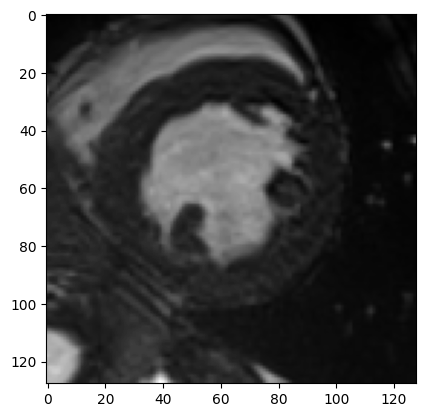

In [3]:
frame_13 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5/patient_4d_frame_13.npy")
print(frame_13.shape)
# load model
plt.imshow(frame_13, cmap='gray')
plt.show()


In [3]:
from tensorflow.keras.losses import Loss
import tensorflow as tf

class MaskLoss(Loss):
    def __init__(self, **kwargs):  # Add kwargs for config compatibility
        super(MaskLoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
        # Extract the first two channels (actual ground truth)
        y_true_deformed = y_true[..., :2]  # Shape: [batch_size, height, width, 2]

        # Extract the third channel (mask)
        mask = y_true[..., 2]  # Shape: [batch_size, height, width]

        # Compute the ratio of foreground to background
        num_foreground = tf.reduce_sum(tf.cast(mask == 1, tf.float32))
        num_background = tf.reduce_sum(tf.cast(mask == 0, tf.float32))

        # Compute final_ratio, ensuring stability
        final_ratio = num_background / (num_foreground + 1e-6)
        final_ratio = tf.clip_by_value(final_ratio, 0.1, 10)  # Prevent extreme values

        # Compute squared error
        squared_error = tf.square(y_true_deformed - y_pred)  # Shape: [batch_size, height, width, 2]

        # Assign higher weight to masked region
        # weighted_mask = tf.where(mask == 1, final_ratio, 1.0)  # Shape: [batch_size, height, width]

        # Expand dimensions to match squared_error shape
        weighted_mask = tf.expand_dims(mask, axis=-1)  # Shape: [batch_size, height, width, 1]

        # Apply weighted loss
        weighted_error = weighted_mask * squared_error

        mask_sum = tf.reduce_sum(weighted_mask)
        num_of_pixels = tf.cast(128 * 128, tf.float32)
        
        mask_ratio = num_of_pixels / (mask_sum + 1e-6)

        weighted_error = weighted_error * mask_ratio

        mean_error = tf.reduce_mean(weighted_error)

        return mean_error
    
    def get_config(self):  # 🚀 Add this to fix the TypeError!
        base_config = super(MaskLoss, self).get_config()
        return base_config

    
class MAELoss(Loss):
    def __init__(self, **kwargs):
        super(MAELoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true[..., :2]  - y_pred))
    
    def get_config(self):  
        base_config = super(MAELoss, self).get_config()
        return base_config

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate, add, Multiply, Lambda
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, UpSampling2D,UpSampling3D, Conv2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Add, Multiply, BatchNormalization, Activation
from tensorflow.keras.models import Model


class Conv_block(tf.keras.Model):
    def __init__(self,num_filters):
        super(Conv_block, self).__init__()
        self.conv1 = Conv2D(num_filters, 3, padding = 'same', kernel_initializer = 'he_normal')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(num_filters, 3, padding = 'same', kernel_initializer = 'he_normal')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({'num_filters': self.num_filters})
        return config

class UpConv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(UpConv_block, self).__init__()
        self.upconv = Conv2DTranspose(num_filters, 3, strides = 2, padding = 'same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')

    def call(self, inputs):
        x = self.upconv(inputs)
        x = self.bn(x)
        x = self.act(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({'num_filters': self.num_filters})
        return config
class Max_pool(tf.keras.Model):
    def __init__(self):
        super(Max_pool, self).__init__()
        self.pool = MaxPooling2D(pool_size = (2,2))

    def call(self, inputs):
        x = self.pool(inputs)
        return x
    
    def get_config(self):
        config = super().get_config()
        return config


class Unet(tf.keras.Model):
    def __init__(self, trainable = True, dtype=None, **kwargs):
        super(Unet, self).__init__()
        self.conv_block1 = Conv_block(64)
        self.pool1 = Max_pool()
        self.conv_block2 = Conv_block(128)
        self.pool2 = Max_pool()
        self.conv_block3 = Conv_block(256)
        self.pool3 = Max_pool()
        self.conv_block4 = Conv_block(512)
        self.pool4 = Max_pool()

        # bottleneck
        self.conv_block5 = Conv_block(1024)

        self.upconv_block1 = UpConv_block(512)
        self.conv_block6 = Conv_block(512)
        self.upconv_block2 = UpConv_block(256)
        self.conv_block7 = Conv_block(256)
        self.upconv_block3 = UpConv_block(128)
        self.conv_block8 = Conv_block(128)
        self.upconv_block4 = UpConv_block(64)
        self.conv_block9 = Conv_block(64)

        self.output_def = Conv2D(2, 1, activation = 'linear')

    def call(self, inputs):
        moving, fixed = inputs
        inputs = concatenate([moving, fixed], axis = -1)

        conv1 = self.conv_block1(inputs)
        pool1 = self.pool1(conv1)
        conv2 = self.conv_block2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv_block3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv_block4(pool3)
        pool4 = self.pool4(conv4)

        # bottleneck
        conv5 = self.conv_block5(pool4)

        upconv1 = self.upconv_block1(conv5)
        concat1 = Concatenate()([conv4, upconv1])
        conv6 = self.conv_block6(concat1)
        upconv2 = self.upconv_block2(conv6)
        concat2 = Concatenate()([conv3, upconv2])
        conv7 = self.conv_block7(concat2)
        upconv3 = self.upconv_block3(conv7)
        concat3 = Concatenate()([conv2, upconv3])
        conv8 = self.conv_block8(concat3)
        upconv4 = self.upconv_block4(conv8)
        concat4 = Concatenate()([conv1, upconv4])
        conv9 = self.conv_block9(concat4)

        output = self.output_def(conv9)
        return output
    
    def get_config(self):
        config = super().get_config()
        return config
    
    

In [40]:
model = tf.keras.models.load_model("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/FrameWork/Models/Unet.keras", custom_objects={'MaskLoss': MaskLoss, 'MAELoss': MAELoss, 'Unet': Unet})


In [41]:
frame1 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient059_frame09_slice_5_ACDC_#5_1.npy")
frame2 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient059_frame09_slice_5_ACDC_#5_2.npy")

frame1 = tf.expand_dims(frame1, axis=0)
frame2 = tf.expand_dims(frame2, axis=0)
predicted = model.predict([frame1, frame2])

/opt/homebrew/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['moving_image', 'fixed_image']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


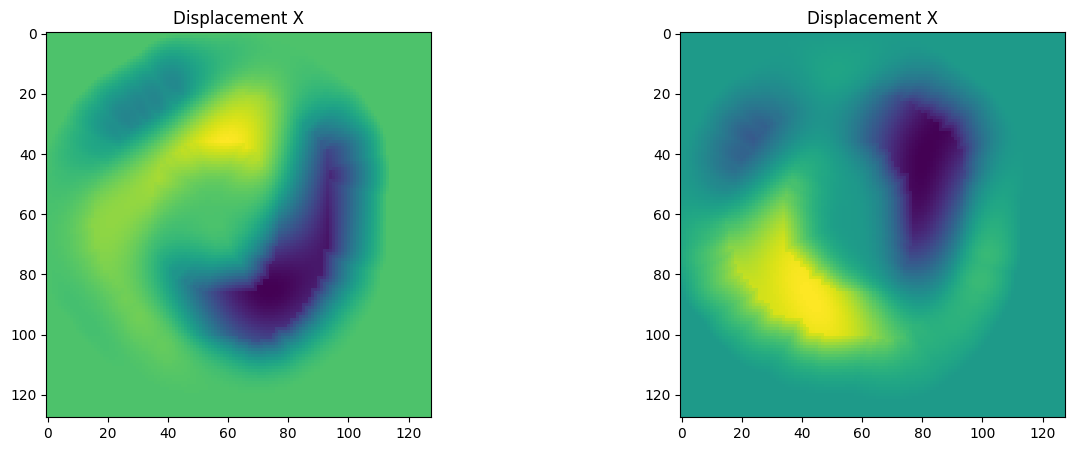

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
x_displ = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient096_frame01_slice_3_ACDC_#0_x.npy")
y_displ = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient096_frame01_slice_3_ACDC_#0_y.npy")
ax[0].imshow(y_displ)
ax[0].set_title('Displacement X')

ax[1].imshow(x_displ)
ax[1].set_title('Displacement X')
plt.show()

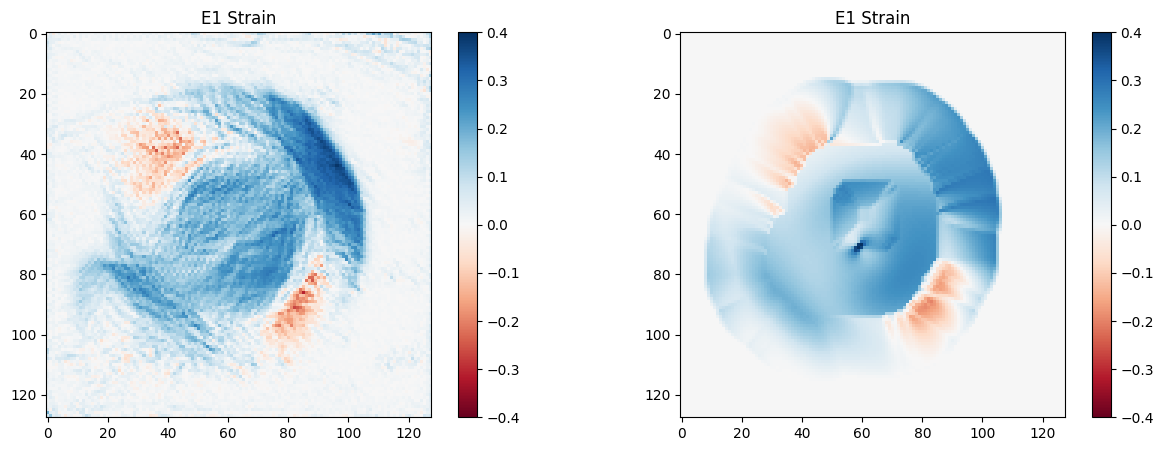

In [43]:
sys.path.append('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2')
from wave_simulation import compute_strains

ep1_p, ep2_p, ep3_p = compute_strains(predicted[0, :, :, 0], predicted[0, :, :, 1], 1,1)
ep1, ep2, ep3 = compute_strains(x_displ, y_displ, 1,1)
# plt.imshow(ep1,cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
im0 = ax[0].imshow(ep1_p, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
ax[0].set_title('E1 Strain')
fig.colorbar(im0, ax=ax[0], orientation='vertical')

im1 = ax[1].imshow(ep1, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
ax[1].set_title('E1 Strain')
fig.colorbar(im1, ax=ax[1], orientation='vertical')

plt.show()



In [5]:
def apply_displacement( image, x_displacement, y_displacement):
        # Prepare meshgrid for remap
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Apply displacement (scale the displacements for more visible effect)
    x_new = (x + x_displacement).astype(np.float32)
    y_new = (y + y_displacement).astype(np.float32)
    # convert image tensor to numpy
    image = image.numpy()
    

    # Warp the image using remap for both x and y displacements
    displaced_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_REFLECT)
    return displaced_image

(128, 128)
(128, 128)


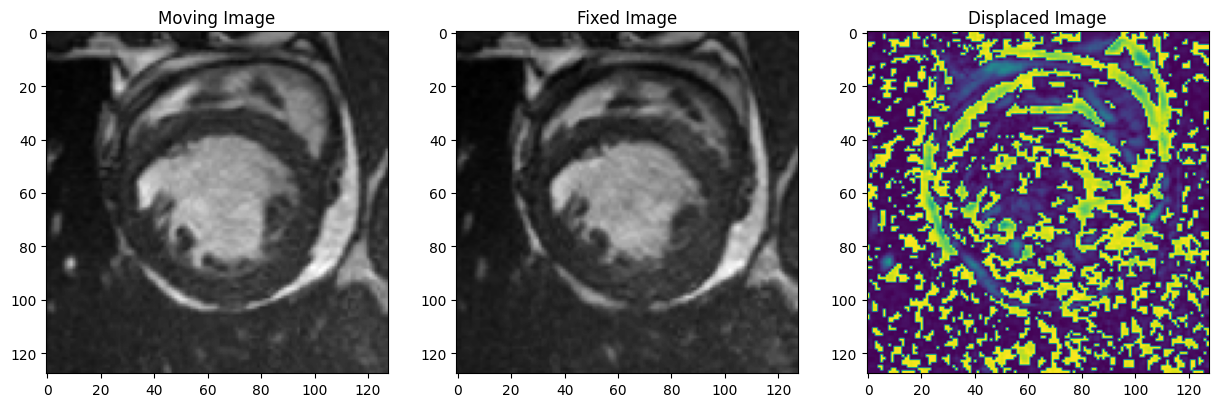

In [42]:
x_displacement_predicted = predicted[0, :, :, 0]  
y_displacement_predicted = predicted[0, :, :, 1]
print(fixed_image[0].shape)
print(x_displacement_predicted.shape)
# Apply the displacement to the fixed image
displaced = apply_displacement(moving_image[0], x_displacement_predicted, y_displacement_predicted)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(moving_image[0], cmap='gray')
ax[0].set_title('Moving Image') 
ax[1].imshow(fixed_image[0], cmap='gray')
ax[1].set_title('Fixed Image')
ax[2].imshow(displaced - fixed_image[0])
ax[2].set_title('Displaced Image')
plt.show()
       

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
def limit_strain_range(displacement_x, displacement_y, strain_upper_bound, stretch = False,
                     reduction_factor=0.99, amplification_factor=1.01, max_iterations=1000, tolerance=1e-6):
        """
        Convert displacement maps to strain tensors using Eulerian strain formulation.
        Iteratively adjust displacements until all strain values are within the specified bounds:
        - Reduce displacements if strain exceeds upper bound
        - Amplify displacements if strain is below lower bound

        Parameters:
        -----------
        displacement_x : numpy.ndarray
            Displacement field in x-direction
        displacement_y : numpy.ndarray
            Displacement field in y-direction
        strain_lower_bound : float
            Minimum desired strain value
        strain_upper_bound : float
            Maximum allowable strain value
        reduction_factor : float, optional
            Factor by which to reduce displacements each iteration (default: 0.99)
        amplification_factor : float, optional
            Factor by which to amplify displacements each iteration (default: 1.01)
        max_iterations : int, optional
            Maximum number of iterations to perform (default: 1000)
        tolerance : float, optional
            Convergence tolerance (default: 1e-6)

        Returns:
        --------
        tuple
            (adjusted_displacement_x, adjusted_displacement_y,
            initial_strain_tensor, final_strain_tensor, max_initial_strain, max_final_strain)
        """
        # Ensure input arrays have the same shape
        if displacement_x.shape != displacement_y.shape:
            raise ValueError("Displacement maps must have the same shape")
        if stretch:
            strain_lower_bound = 0.01
        else:
            strain_lower_bound = 0

        # Make copies of the input arrays to avoid modifying the originals
        dx = displacement_x.copy()
        dy = displacement_y.copy()

        # Create gradient operators for calculating spatial derivatives
        y_size, x_size = dx.shape

        # Calculate initial strain tensor
        # Calculate displacement gradients using central differences
        dudx_initial = np.zeros_like(dx)
        dudy_initial = np.zeros_like(dx)
        dvdx_initial = np.zeros_like(dx)
        dvdy_initial = np.zeros_like(dx)

        # Interior points (central differences)
        dudx_initial[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
        dudy_initial[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
        dvdx_initial[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
        dvdy_initial[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

        # Edges (forward/backward differences)
        # Left edge
        dudx_initial[:, 0] = dx[:, 1] - dx[:, 0]
        dvdx_initial[:, 0] = dy[:, 1] - dy[:, 0]
        # Right edge
        dudx_initial[:, -1] = dx[:, -1] - dx[:, -2]
        dvdx_initial[:, -1] = dy[:, -1] - dy[:, -2]
        # Top edge
        dudy_initial[0, :] = dx[1, :] - dx[0, :]
        dvdy_initial[0, :] = dy[1, :] - dy[0, :]
        # Bottom edge
        dudy_initial[-1, :] = dx[-1, :] - dx[-2, :]
        dvdy_initial[-1, :] = dy[-1, :] - dy[-2, :]

        # Calculate Eulerian strain tensor components
        # E = 1/2 * (∇u + ∇u^T + ∇u^T∇u)
        E_xx_initial = 0.5 * (2*dudx_initial + dudx_initial**2 + dvdx_initial**2)
        E_yy_initial = 0.5 * (2*dvdy_initial + dudy_initial**2 + dvdy_initial**2)
        E_xy_initial = 0.5 * (dudy_initial + dvdx_initial + dudx_initial*dudy_initial + dvdx_initial*dvdy_initial)
        E_yx_initial = E_xy_initial

        # Calculate principal strains
        avg_normal_strain_initial = (E_xx_initial + E_yy_initial) / 2
        diff_normal_strain_initial = (E_xx_initial - E_yy_initial) / 2
        radius_initial = np.sqrt(diff_normal_strain_initial**2 + E_xy_initial**2)


        E1_initial = avg_normal_strain_initial + radius_initial  # Maximum principal strain
        E2_initial = avg_normal_strain_initial - radius_initial  # Minimum principal strain

        # KHZ 250318: Corrected the calculation of principal strains
        E_xx_initial = 0.5 * (2*dudx_initial - dudx_initial**2 - dvdx_initial**2)
        E_yy_initial = 0.5 * (2*dvdy_initial - dudy_initial**2 - dvdy_initial**2)
        E_xy_initial = 0.5 * (dudy_initial + dvdx_initial - dudx_initial*dudy_initial - dvdx_initial*dvdy_initial)

        E1_initial = (E_xx_initial + E_yy_initial) / 2 + np.sqrt(((E_xx_initial - E_yy_initial) / 2) ** 2 + ((E_xy_initial + E_yx_initial) / 2) ** 2)
        E2_initial = (E_xx_initial + E_yy_initial) / 2 - np.sqrt(((E_xx_initial - E_yy_initial) / 2) ** 2 + ((E_xy_initial + E_yx_initial) / 2) ** 2)
        # KHZ 250318: Corrected the calculation of principal strains


        # Find maximum and minimum absolute strain values
        max_initial_strain = max(np.max(np.abs(E1_initial)), np.max(np.abs(E2_initial)))
        min_initial_strain = min(np.min(np.abs(E1_initial)), np.min(np.abs(E2_initial)))

        # Store initial strain tensor
        initial_strain_tensor = {
            'E_xx': E_xx_initial,
            'E_yy': E_yy_initial,
            'E_xy': E_xy_initial,
            'E1': E1_initial,
            'E2': E2_initial,
            'min_abs_strain': min_initial_strain,
            'max_abs_strain': max_initial_strain
        }

        # If initial strain is already within bounds, no need to iterate
        if (max_initial_strain <= strain_upper_bound) and (min_initial_strain >= strain_lower_bound):
            return dx, dy, initial_strain_tensor, initial_strain_tensor, max_initial_strain, max_initial_strain, min_initial_strain, min_initial_strain

        # Otherwise, proceed with iterative adjustment
        iterations = 0
        max_strain = max_initial_strain
        min_strain = min_initial_strain
        prev_max_strain = float('inf')
        prev_min_strain = 0

        # Initialize strain tensor components for the loop
        E_xx = E_xx_initial.copy()
        E_yy = E_yy_initial.copy()
        E_xy = E_xy_initial.copy()
        E1 = E1_initial.copy()
        E2 = E2_initial.copy()

        while ((max_strain > strain_upper_bound) or (min_strain < strain_lower_bound)) and (iterations < max_iterations):
            # Determine whether to reduce or amplify displacements
            if max_strain > strain_upper_bound:
                # Reduce displacements if above upper bound
                adjustment_factor = reduction_factor
            elif min_strain < strain_lower_bound:
                # Amplify displacements if below lower bound
                adjustment_factor = amplification_factor
            else:
                # This shouldn't happen due to the while condition, but just in case
                break

            # Apply adjustment
            dx *= adjustment_factor
            dy *= adjustment_factor

            # Recalculate displacement gradients
            dudx = np.zeros_like(dx)
            dudy = np.zeros_like(dx)
            dvdx = np.zeros_like(dx)
            dvdy = np.zeros_like(dx)

            # Interior points (central differences)
            dudx[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
            dudy[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
            dvdx[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
            dvdy[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

            # Edges (forward/backward differences)
            # Left edge
            dudx[:, 0] = dx[:, 1] - dx[:, 0]
            dvdx[:, 0] = dy[:, 1] - dy[:, 0]
            # Right edge
            dudx[:, -1] = dx[:, -1] - dx[:, -2]
            dvdx[:, -1] = dy[:, -1] - dy[:, -2]
            # Top edge
            dudy[0, :] = dx[1, :] - dx[0, :]
            dvdy[0, :] = dy[1, :] - dy[0, :]
            # Bottom edge
            dudy[-1, :] = dx[-1, :] - dx[-2, :]
            dvdy[-1, :] = dy[-1, :] - dy[-2, :]

            # Calculate Eulerian strain tensor components
            # E = 1/2 * (∇u + ∇u^T + ∇u^T∇u)
            E_xx = 0.5 * (2*dudx + dudx**2 + dvdx**2)
            E_yy = 0.5 * (2*dvdy + dudy**2 + dvdy**2)
            E_xy = 0.5 * (dudy + dvdx + dudx*dudy + dvdx*dvdy)

            # Calculate principal strains
            avg_normal_strain = (E_xx + E_yy) / 2
            diff_normal_strain = (E_xx - E_yy) / 2
            radius = np.sqrt(diff_normal_strain**2 + E_xy**2)

            E1 = avg_normal_strain + radius  # Maximum principal strain
            E2 = avg_normal_strain - radius  # Minimum principal strain

            # Find maximum and minimum absolute strain values
            max_strain = max(np.max(np.abs(E1)), np.max(np.abs(E2)))
            min_strain = min(np.min(np.abs(E1)), np.min(np.abs(E2)))

            # Check convergence
            if (abs(max_strain - prev_max_strain) < tolerance and
                abs(min_strain - prev_min_strain) < tolerance):
                break

            prev_max_strain = max_strain
            prev_min_strain = min_strain
            iterations += 1

        # Prepare final strain tensor
        final_strain_tensor = {
            'E_xx': E_xx,
            'E_yy': E_yy,
            'E_xy': E_xy,
            'E1': E1,
            'E2': E2,
            'min_abs_strain': min_strain,
            'max_abs_strain': max_strain
        }

        return dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain




def create_interactive_plots(data, sample_idx, MODEL_TESTING_PATH):
    """
    Create interactive plots with core images, strain analysis, and strain overlays.

    Parameters:
    -----------
    data : dict
        Dictionary containing:
        - 'moving': Moving images (numpy array).
        - 'fixed': Fixed images (numpy array).
        - 'warped': Warped images (numpy array).
        - 'displacements': Displacement fields (numpy array).
    sample_idx : int, optional
        Index of the sample to plot (default: 0).

    Returns:
    --------
    None
        Displays the plots.
    """
    # Extract data for the selected sample
    moving = data['moving']
    fixed = data['fixed']
    warped = data['warped']
    disp = data['displacements']

    # Calculate strain using the displacement fields
    result = limit_strain_range(disp[..., 0], disp[..., 1], strain_upper_bound=1, stretch=False)
    dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = result
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    im1 = ax[0].imshow(final_strain_tensor['E1'], cmap='jet', vmin=-0.4, vmax=0.4)
    ax[0].set_title('E1 Strain')
    fig.colorbar(im1, ax=ax[0])

    im2 = ax[1].imshow(final_strain_tensor['E2'], cmap='jet', vmin=-0.4, vmax=0.4)
    ax[1].set_title('E2 Strain')
    fig.colorbar(im2, ax=ax[1])

    im3 = ax[2].imshow(disp[...,0]+disp[...,1], cmap='jet')
    ax[2].set_title('Displacement')
    fig.colorbar(im3, ax=ax[2])
    plt.show()
    # Create a figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 5, figsize=(40, 21), constrained_layout=True)
    fig.suptitle(f"Sample {sample_idx} Analysis", fontsize=20, y=1.02)

    # --- First Row: Core Images ---
    images = [moving, fixed, warped]
    titles = ["Moving Image", "Fixed Image", "Warped Image"]

    Current_Row=0

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[Current_Row, i].imshow(img, cmap='gray')
        axes[Current_Row, i].set_title(title, fontsize=16)
        axes[Current_Row, i].axis('off')

    # Create RGB image: R and G from warped, B from fixed
    warped_norm = (warped - warped.min()) / (np.ptp(warped))
    fixed_norm = (fixed - fixed.min()) / (np.ptp(fixed))
    moving_norm = (moving - moving.min()) / (np.ptp(moving))

    rgb_wrpd_fxd = np.stack([
        warped_norm,      # Red channel
        fixed_norm,      # Green channel
        fixed_norm        # Blue channel
    ], axis=-1)

    axes[Current_Row, 3].imshow(rgb_wrpd_fxd)
    axes[Current_Row, 3].set_title("Warped (Red) over Fixed (RGB)", fontsize=20)
    axes[Current_Row, 3].axis('off')

    rgb_mvg_fxd = np.stack([
        moving_norm,      # Red channel
        fixed_norm,      # Green channel
        fixed_norm        # Blue channel
    ], axis=-1)

    axes[Current_Row, 4].imshow(rgb_mvg_fxd)
    axes[Current_Row, 4].set_title("Moving (Red) over Fixed (RGB)", fontsize=20)
    axes[Current_Row, 4].axis('off')


    # --- Second Row: Strain Analysis (Heatmaps) ---
    Current_Row=2
    # Auto-adjust color limits for E1 and E2 strains
    strain_min = min(np.min(final_strain_tensor['E1']), np.min(final_strain_tensor['E2']))
    strain_max = max(np.max(final_strain_tensor['E1']), np.max(final_strain_tensor['E2']))
    abs_max = max(abs(strain_min), abs(strain_max))
    vmin, vmax = -abs_max, abs_max  # Symmetric colormap
    vmin, vmax = -0.5, 0.5  # Symmetric colormap

    strain_images = [final_strain_tensor['E1'], final_strain_tensor['E2']]
    strain_titles = ["Final E1 Strain", "Final E2 Strain"]


    for i, (strain_img, title) in enumerate(zip(strain_images, strain_titles)):
        im = axes[Current_Row, i].imshow(strain_img[150:350,150:350], cmap='jet', vmin=vmin, vmax=vmax)
        axes[Current_Row, i].set_title(title, fontsize=16)
        axes[Current_Row, i].axis('off')
        add_colorbar(fig, axes[Current_Row, i], im, label="Strain (unitless)")

    # Warped Difference Image (Use Signed Differences)
    diff = fixed - warped
    im6 = axes[Current_Row, 2].imshow(diff, cmap='bwr', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
    axes[Current_Row, 2].set_title("Warped Difference", fontsize=16)
    axes[Current_Row, 2].axis('off')
    add_colorbar(fig, axes[Current_Row, 2], im6, label="Intensity Difference")

    axes[Current_Row, 3].axis('off')
    axes[Current_Row, 4].axis('off')



    # --- Third Row: Strain Overlays on Fixed Image ---
    Current_Row=1
    overlay_titles = ["E1 Strain Overlay", "E2 Strain Overlay"]

    for i, (strain_img, title) in enumerate(zip(strain_images, overlay_titles)):
        # Display fixed image in grayscale
        axes[Current_Row, i].imshow(moving[150:350,15:350], cmap='gray', alpha=0.95)
        # Overlay strain with semi-transparency
        im_overlay = axes[Current_Row, i].imshow(strain_img[150:350,15:350], cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
        axes[Current_Row, i].set_title(title, fontsize=16)
        axes[Current_Row, i].axis('off')
        add_colorbar(fig, axes[Current_Row, i], im_overlay, label="Strain (unitless)")

    # Compute local absolute error
    error_map = np.abs(fixed_norm - warped_norm)

    im = axes[Current_Row, 3].imshow(error_map, cmap='hot')
    axes[Current_Row, 3].set_title("F-W Local Registration Error Heatmap", fontsize=16)
    axes[Current_Row, 3].axis('off')
    add_colorbar(fig, axes[Current_Row, 3], im, label="Absolute Intensity Difference")

    error_map = np.abs(fixed_norm - moving_norm)
    im = axes[Current_Row, 4].imshow(error_map, cmap='hot')
    axes[Current_Row, 4].set_title("F-M Local Registration Error Heatmap", fontsize=16)
    axes[Current_Row, 4].axis('off')
    add_colorbar(fig, axes[Current_Row, 4], im, label="Absolute Intensity Difference")



    axes[Current_Row, 2].axis('off')


    plt.show()


def add_colorbar(fig, ax, im, label=""):
    """
    Add a standardized colorbar to a plot axis.

    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure containing the plot.
    ax : matplotlib.axes.Axes
        The axis to which the colorbar will be added.
    im : matplotlib.image.AxesImage
        The image for which the colorbar is created.
    label : str, optional
        Label for the colorbar.

    Returns:
    --------
    None
        Adds a colorbar to the specified axis.
    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

def apply_displacement( image, x_displacement, y_displacement):
        # Prepare meshgrid for remap
        height, width = image.shape
        x, y = np.meshgrid(np.arange(width), np.arange(height))

        # Apply displacement (scale the displacements for more visible effect)
        x_new = (x + x_displacement).astype(np.float32)
        y_new = (y + y_displacement).astype(np.float32)
        # convert image tensor to numpy
        # image = image.numpy()
        

        # Warp the image using remap for both x and y displacements
        displaced_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_REFLECT)
        return displaced_image


(512, 512)
(512, 512)
(512, 512)


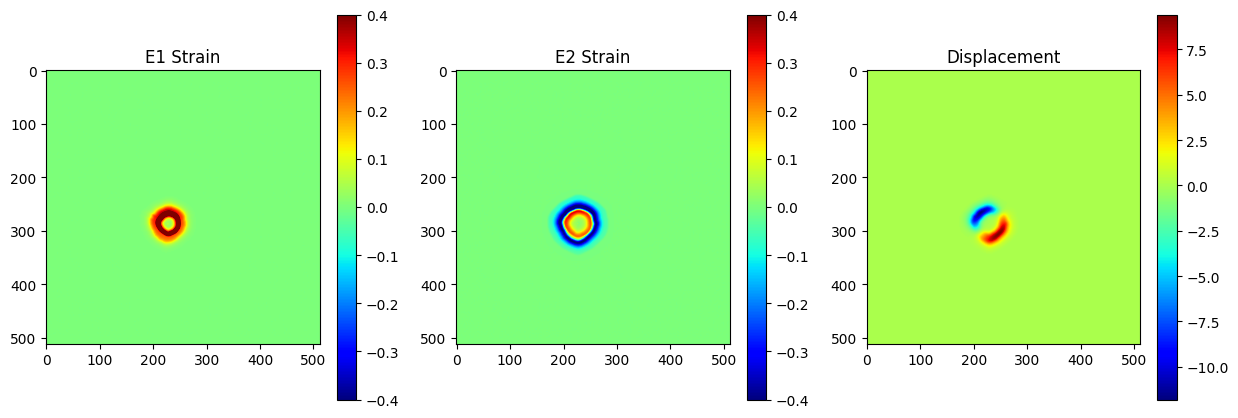

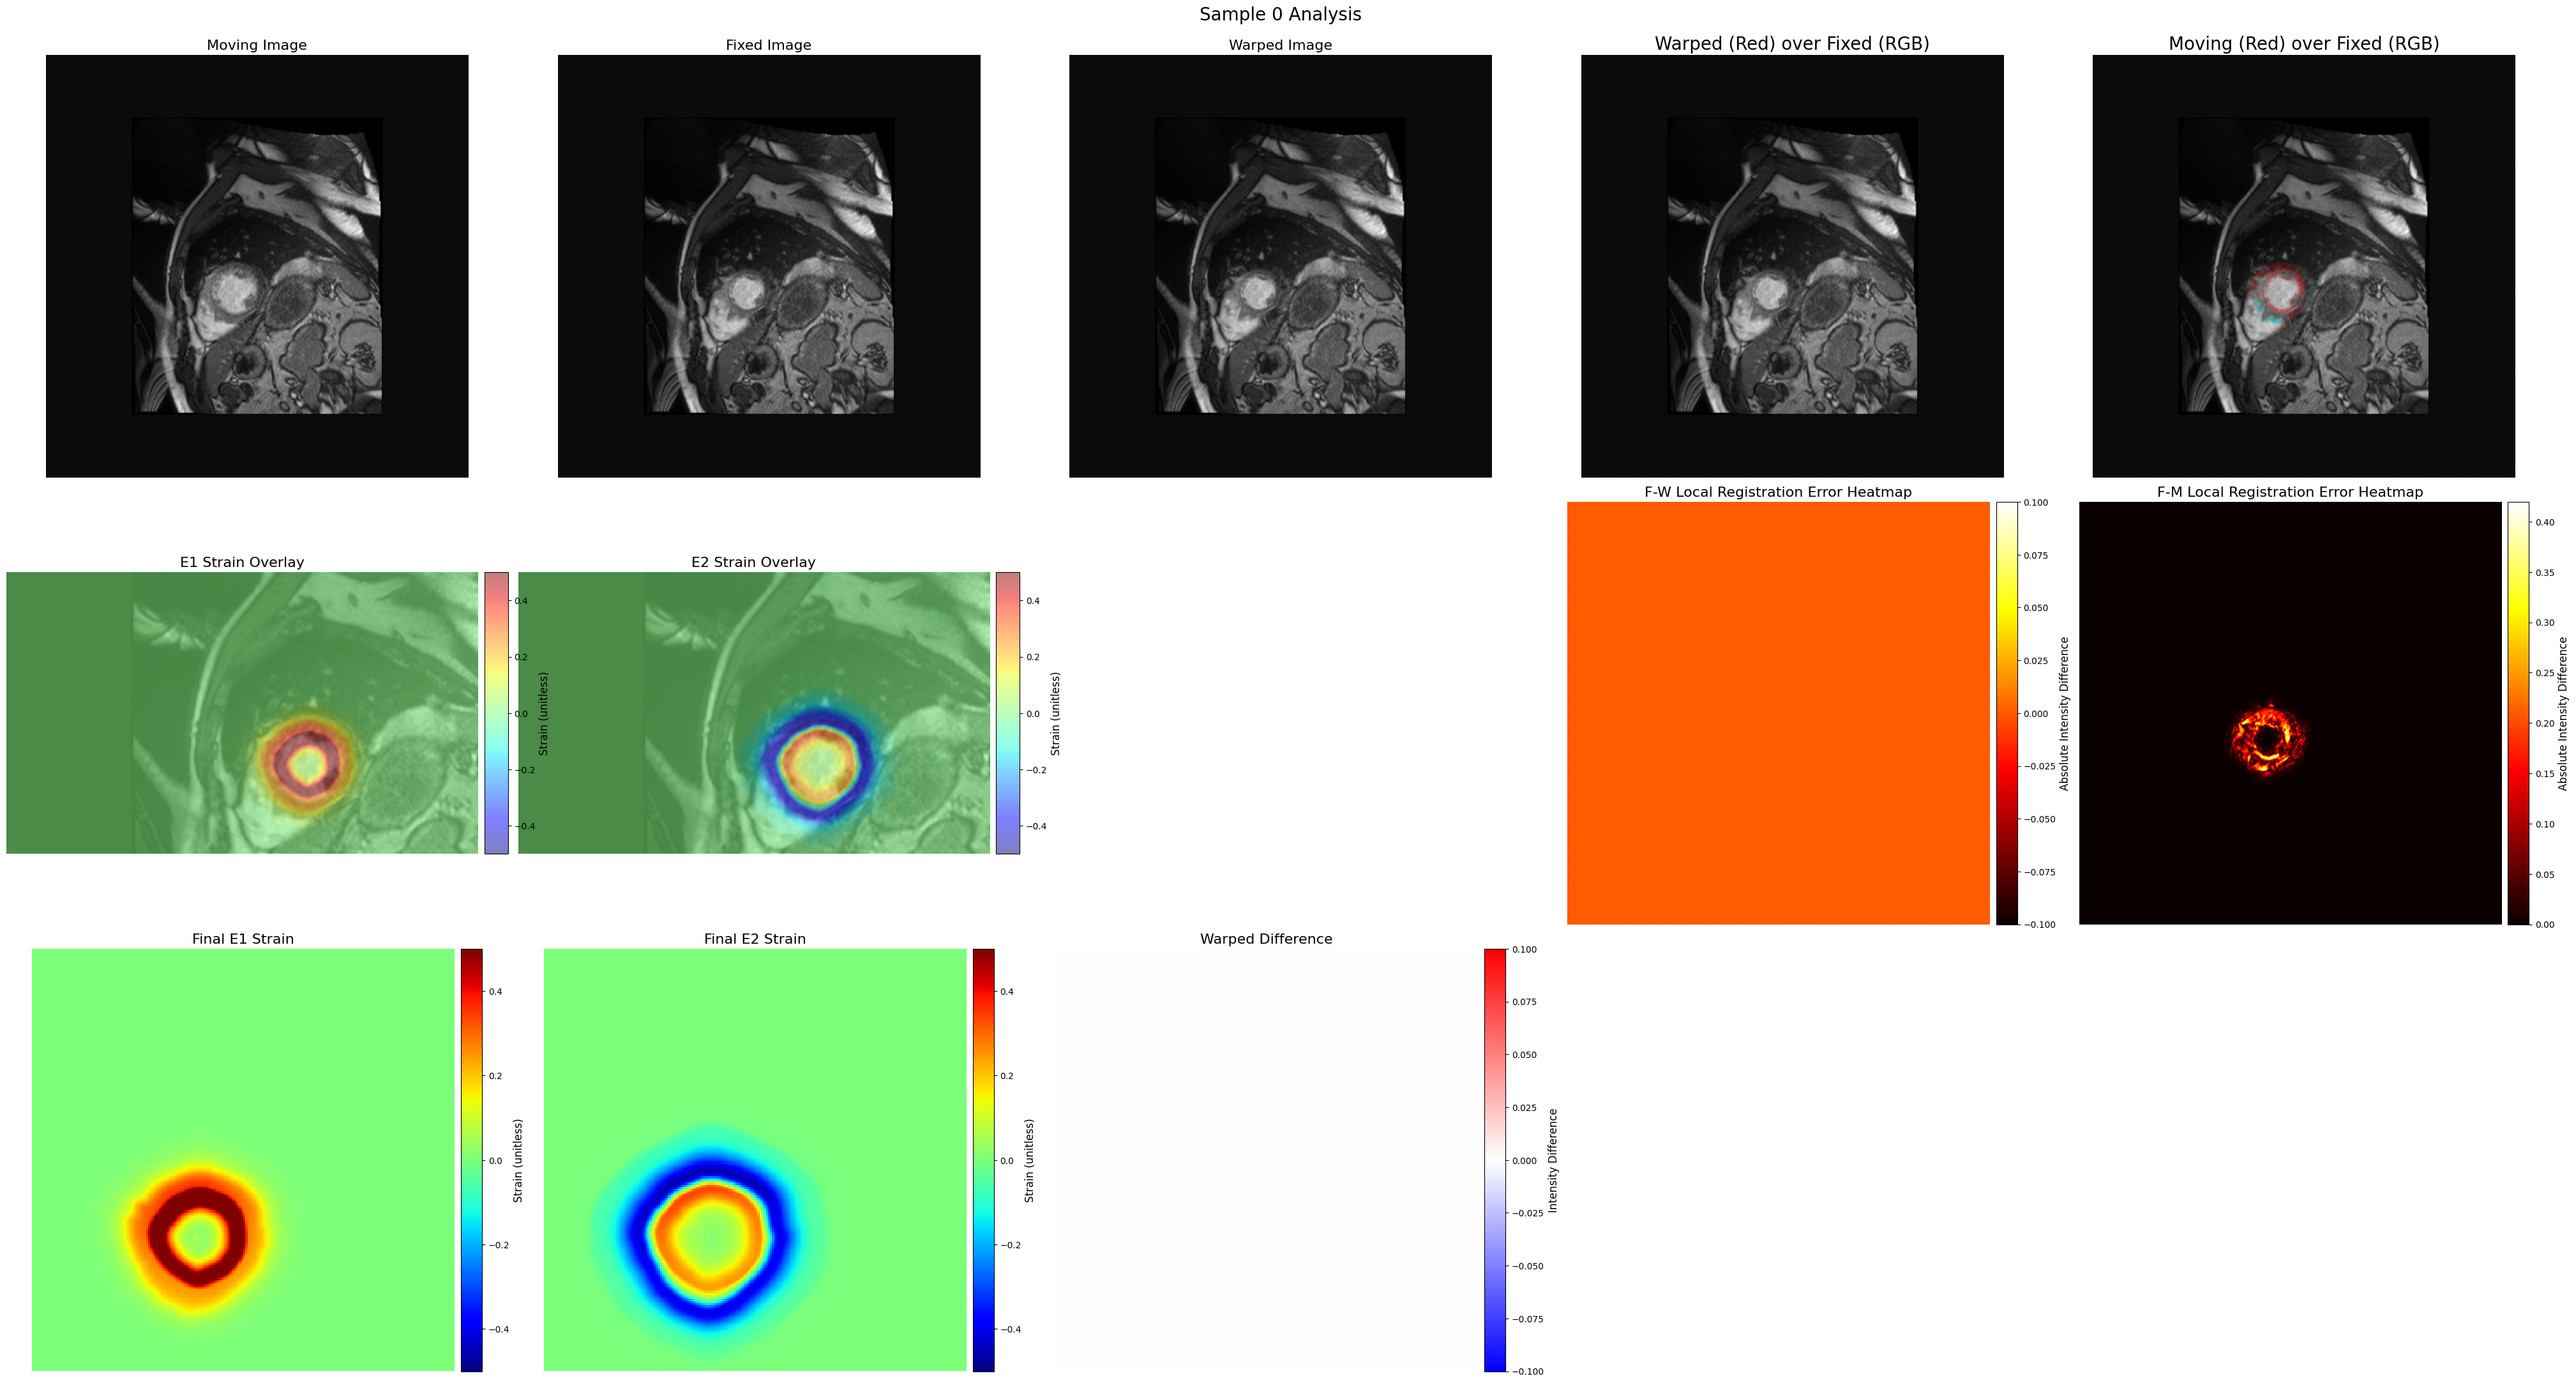

In [24]:
frame1 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient058_frame01_slice_3_ACDC_#5_1.npy")
frame2 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient058_frame01_slice_3_ACDC_#5_2.npy")

# frame1_e = np.expand_dims(frame1, axis=-1)
displacement_x = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient058_frame01_slice_3_ACDC_#5_x.npy")
displacement_y =  np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient058_frame01_slice_3_ACDC_#5_y.npy")
frame1 = frame1[..., 0]
frame2 = frame2[..., 0]
warped = apply_displacement(frame1, displacement_x, displacement_y)
# image1 = image1[..., 0]
# image2 = image2[..., 0]
# warped = warped[..., 0]
print(frame1.shape)
print(displacement_x.shape)
print(warped.shape)
create_interactive_plots({
    'moving': frame1,
    'fixed': frame2,
    'warped': warped,
    'displacements': np.stack([displacement_x, displacement_y], axis=-1)
}, 0, None)

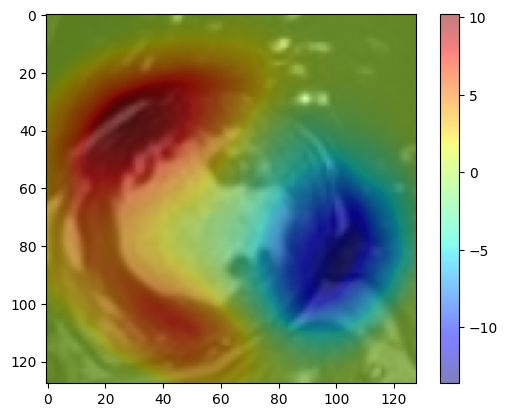

In [54]:
plt.imshow(image1, cmap='gray')
magnitude_disp = np.sqrt(displacement_y**2 + displacement_x**2)
displ = displacement_x + displacement_y
plt.imshow(displ, cmap='jet', alpha=0.5)
plt.colorbar()

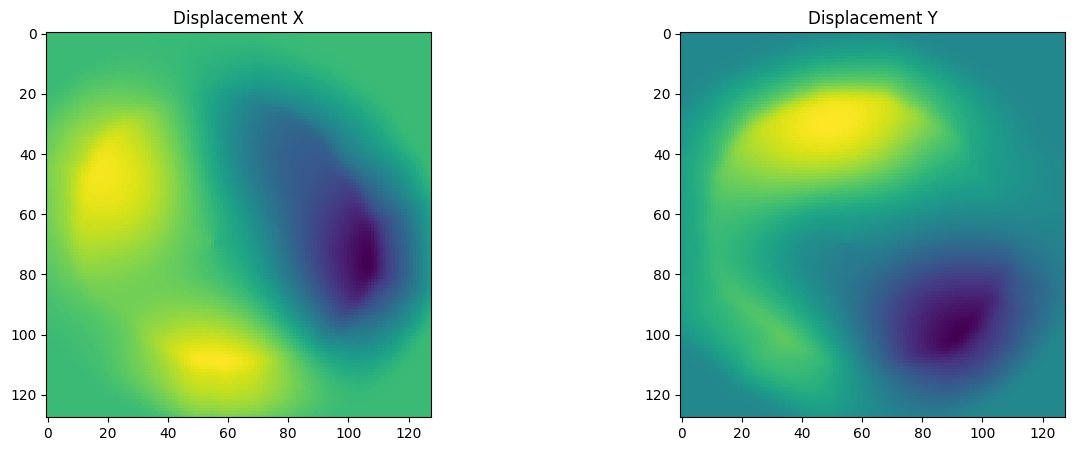

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(displacement_x)
ax[0].set_title('Displacement X')
ax[1].imshow(displacement_y)
ax[1].set_title('Displacement Y')
plt.show()

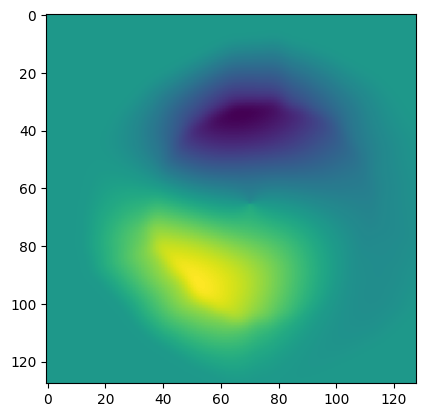

In [47]:
plt.imshow(displacement_y)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate, add, Multiply, Lambda
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, UpSampling2D,UpSampling3D, Conv2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Add, Multiply, BatchNormalization, Activation
from tensorflow.keras.models import Model
class Conv_block(tf.keras.Model):
    def __init__(self,num_filters, kernel_size=3):
        super(Conv_block, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size, padding = 'same', kernel_initializer = 'he_normal')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(num_filters, kernel_size, padding = 'same', kernel_initializer = 'he_normal')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x

class UpConv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(UpConv_block, self).__init__()
        self.upconv = Conv2DTranspose(num_filters, 3, strides = 2, padding = 'same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')

    def call(self, inputs):
        x = self.upconv(inputs)
        x = self.bn(x)
        x = self.act(x)
        return x

class Max_pool(tf.keras.Model):
    def __init__(self):
        super(Max_pool, self).__init__()
        self.pool = MaxPooling2D(pool_size = (2,2))

    def call(self, inputs):
        x = self.pool(inputs)
        return x

class Unet_5Kernel(tf.keras.Model):
    def __init__(self,trainable = True, dtype=None, **kwargs):
        super(Unet_5Kernel, self).__init__()
        self.conv_block1 = Conv_block(64,5)
        self.pool1 = Max_pool()
        self.conv_block2 = Conv_block(128,3)
        self.pool2 = Max_pool()
        self.conv_block3 = Conv_block(256,3)
        self.pool3 = Max_pool()
        self.conv_block4 = Conv_block(512,3)
        self.pool4 = Max_pool()

        # bottleneck
        self.conv_block5 = Conv_block(1024,3)

        self.upconv_block1 = UpConv_block(512)
        self.conv_block6 = Conv_block(512)
        self.upconv_block2 = UpConv_block(256)
        self.conv_block7 = Conv_block(256)
        self.upconv_block3 = UpConv_block(128)
        self.conv_block8 = Conv_block(128)
        self.upconv_block4 = UpConv_block(64)
        self.conv_block9 = Conv_block(64)

        self.output_def = Conv2D(2, 1, activation = 'linear')

    def call(self, inputs):
        moving, fixed = inputs
        inputs = concatenate([moving, fixed], axis = -1)

        conv1 = self.conv_block1(inputs)
        pool1 = self.pool1(conv1)
        conv2 = self.conv_block2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv_block3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv_block4(pool3)
        pool4 = self.pool4(conv4)

        # bottleneck
        conv5 = self.conv_block5(pool4)

        upconv1 = self.upconv_block1(conv5)
        concat1 = Concatenate()([conv4, upconv1])
        conv6 = self.conv_block6(concat1)
        upconv2 = self.upconv_block2(conv6)
        concat2 = Concatenate()([conv3, upconv2])
        conv7 = self.conv_block7(concat2)
        upconv3 = self.upconv_block3(conv7)
        concat3 = Concatenate()([conv2, upconv3])
        conv8 = self.conv_block8(concat3)
        upconv4 = self.upconv_block4(conv8)
        concat4 = Concatenate()([conv1, upconv4])
        conv9 = self.conv_block9(concat4)

        output = self.output_def(conv9)
        return output




In [8]:
model5 = tf.keras.models.load_model("/Users/ahmed_ali/Downloads/Unet_5Kernel.keras", custom_objects={'Unet_5Kernel': Unet_5Kernel})

In [45]:
frame1 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient030_frame12_slice_4_ACDC_#4_1.npy")
frame2 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient030_frame12_slice_4_ACDC_#4_2.npy")

frame1 = tf.expand_dims(frame1, axis=0)
frame2 = tf.expand_dims(frame2, axis=0)
predicted = model5.predict([frame1, frame2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


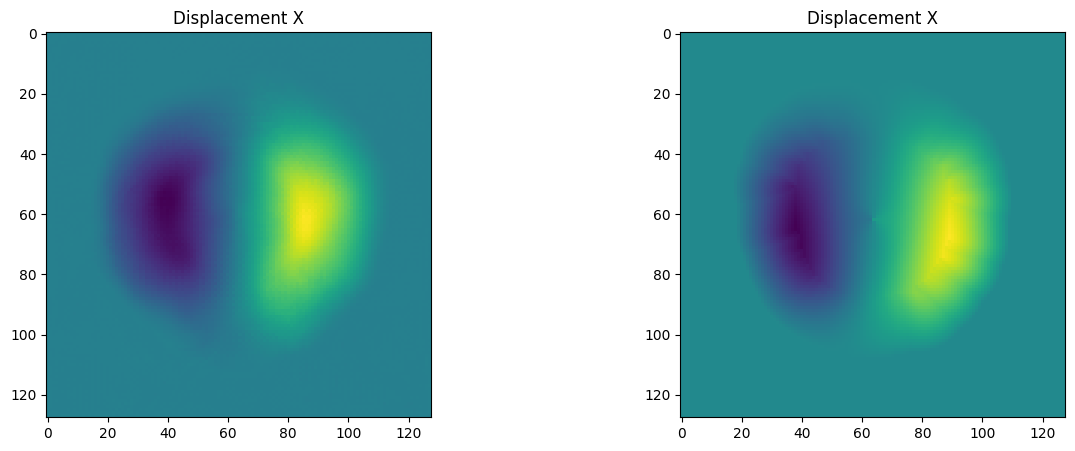

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(predicted[0, :, :, 0])
ax[0].set_title('Displacement X')
x_displ = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Cropped_Displacements/patient030_frame12_slice_4_ACDC_#4_x.npy")
y_displ = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Cropped_Displacements/patient030_frame12_slice_4_ACDC_#4_y.npy")
ax[1].imshow(x_displ)
ax[1].set_title('Displacement X')
plt.show()

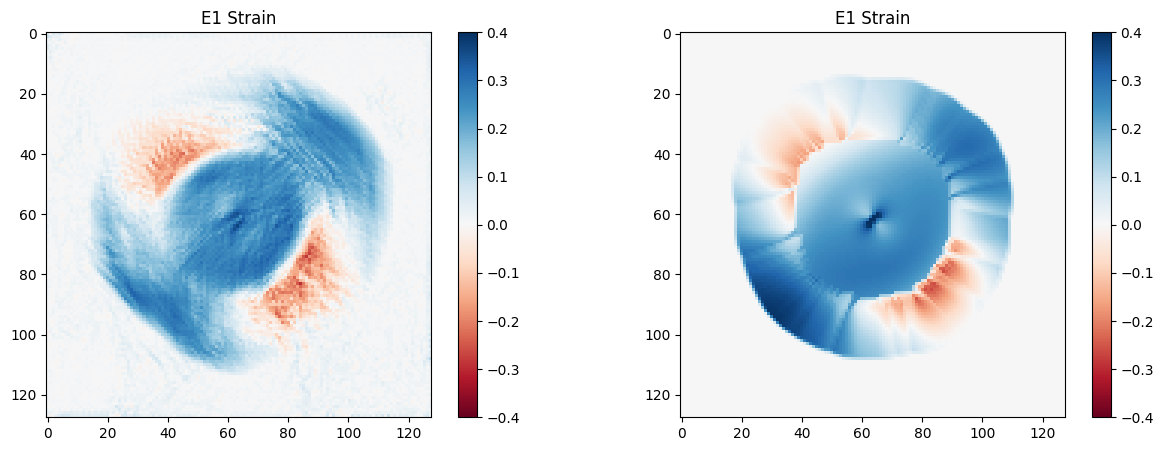

In [47]:
sys.path.append('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2')
from wave_simulation import compute_strains

ep1_p, ep2_p, ep3_p = compute_strains(predicted[0, :, :, 0], predicted[0, :, :, 1], 1,1)
ep1, ep2, ep3 = compute_strains(x_displ, y_displ, 1,1)
# plt.imshow(ep1,cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
im0 = ax[0].imshow(ep1_p, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
ax[0].set_title('E1 Strain')
fig.colorbar(im0, ax=ax[0], orientation='vertical')

im1 = ax[1].imshow(ep1, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
ax[1].set_title('E1 Strain')
fig.colorbar(im1, ax=ax[1], orientation='vertical')

plt.show()



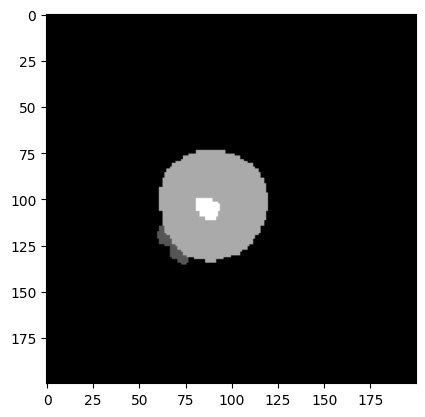

In [59]:
mask = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy/patient030/patient030_frame12_slice_4_ACDC.npy")
mask = mask[1,...]
plt.imshow(mask[150:350,150:350], cmap='gray')
plt.show()

In [56]:
frame1 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient058_frame01_slice_1_ACDC_#2_1.npy")
frame2 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient058_frame01_slice_1_ACDC_#2_2.npy")
x_displ = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Cropped_Displacements/patient058_frame01_slice_1_ACDC_#2_x.npy")
y_displ = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Cropped_Displacements/patient058_frame01_slice_1_ACDC_#2_y.npy")
frame1 = tf.expand_dims(frame1, axis=0)
frame2 = tf.expand_dims(frame2, axis=0)
predicted = model5.predict([frame1, frame2])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


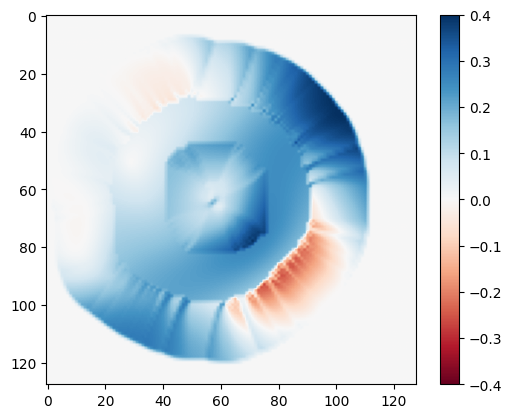

In [62]:
sys.path.append('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2')
from wave_simulation import compute_strains

ep1_p, ep2_p, ep3_p = compute_strains(predicted[0, :, :, 0], predicted[0, :, :, 1], 1,1)
ep1, ep2, ep3 = compute_strains(x_displ, y_displ, 1,1)
# plt.imshow(ep1,cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# # im0 = ax[0].imshow(ep1_p, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
# # ax[0].set_title('E1 Strain')
# # fig.colorbar(im0, ax=ax[0], orientation='vertical')

# im1 = ax[0].imshow(ep1, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
# ax[0].set_title('E1 Strain')
# fig.colorbar(im1, ax=ax[0], orientation='vertical')
plt.imshow(ep1, cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)
plt.colorbar()

plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


/var/folders/v2/vml429gj3w93xjbkkns2f7d80000gn/T/ipykernel_34815/1838929440.py:319: RuntimeWarning: overflow encountered in scalar negative
  im6 = axes[Current_Row, 2].imshow(diff, cmap='bwr', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))


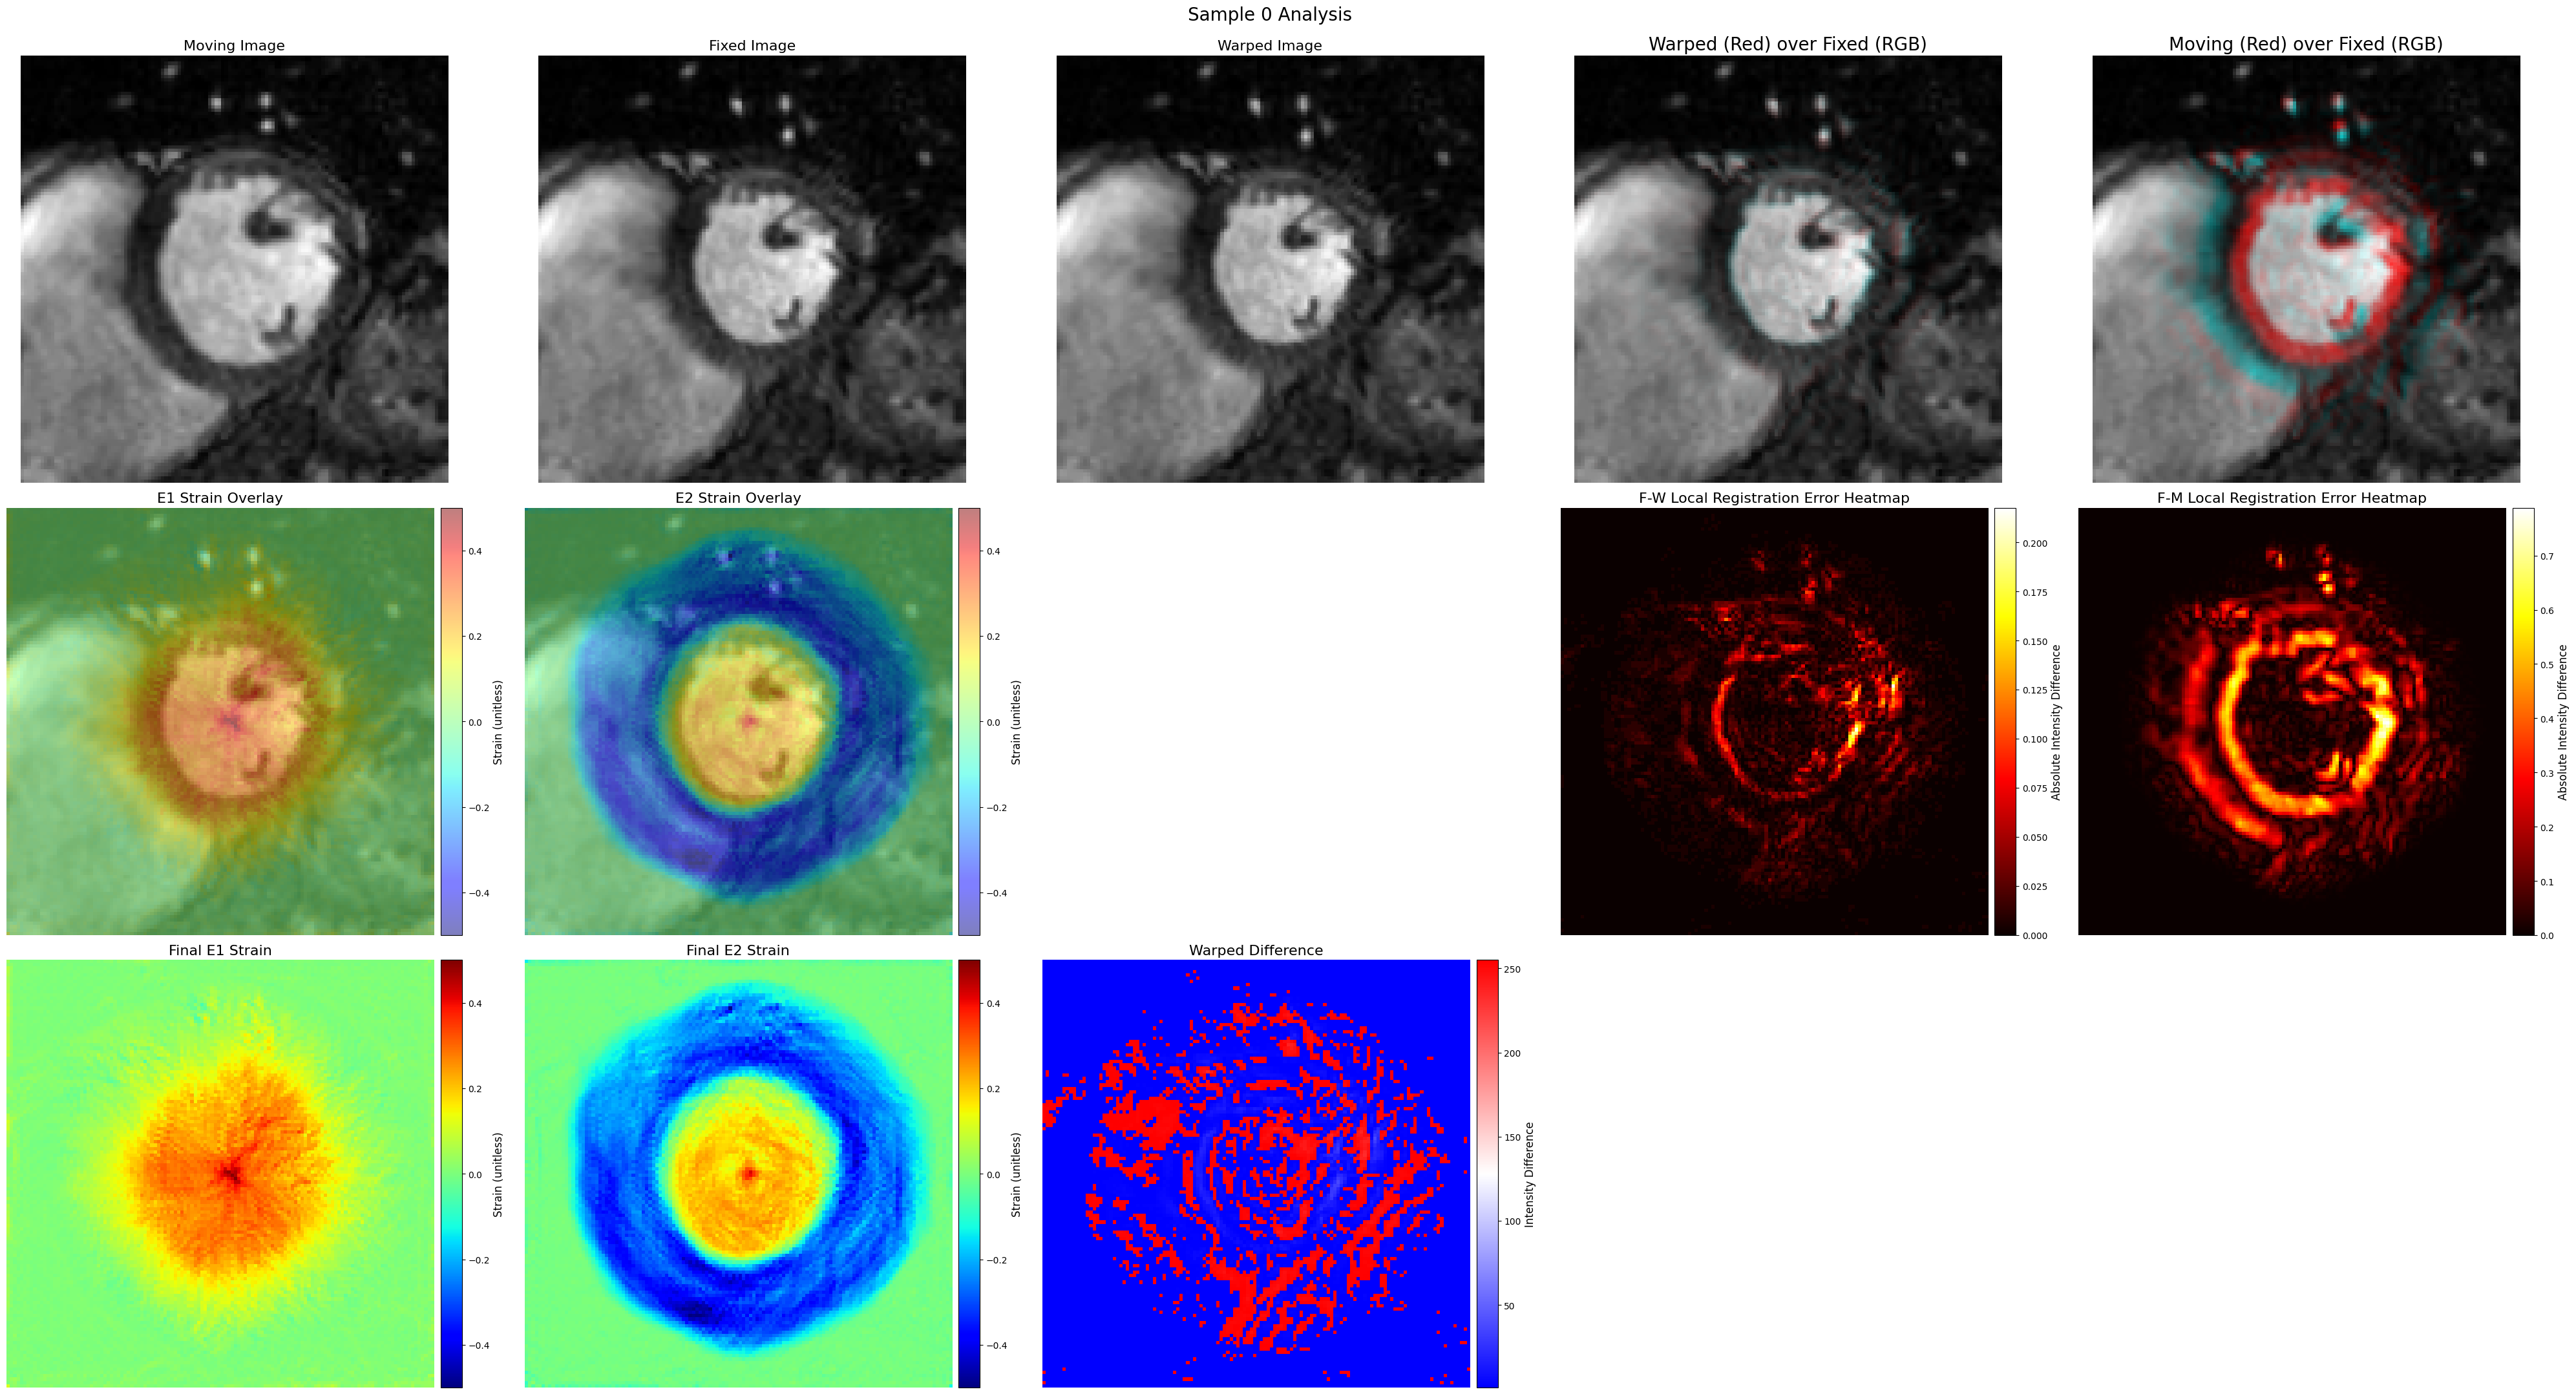

In [42]:
# expand the images to have a batch dimension
image1_e = np.expand_dims(image1, axis=0)
image2_e = np.expand_dims(image2, axis=0)
displacement = model5.predict([image1_e, image2_e])
displacement_x = displacement[0, :, :, 0]
displacement_y = displacement[0, :, :, 1]
image1_d = np.expand_dims(image1, axis=-1)
# Apply the displacement to the fixed image
displaced = apply_displacement(image1_d, displacement_x, displacement_y)
create_interactive_plots({
    'moving': image1,
    'fixed': image2,
    'warped': displaced,
    'displacements': np.stack([displacement_x, displacement_y], axis=-1)
}, 0, None)

In [24]:
def enforce_full_principal_strain_order(Ep1All, Ep2All, Ep3All=None):
        """
        Ensure Ep1All >= Ep2All >= Ep3All at every voxel (pixel) location.
        Sorts the three principal strains per point.

        Args:
            Ep1All (np.ndarray): First principal strain field.
            Ep2All (np.ndarray): Second principal strain field.
            Ep3All (np.ndarray): Third principal strain field (incompressibility strain).

        Returns:
            Ep1_sorted (np.ndarray): Largest principal strain.
            Ep2_sorted (np.ndarray): Middle principal strain.
            Ep3_sorted (np.ndarray): Smallest principal strain.
        """

        if Ep3All is not None:
            # Stack all principal strains along a new axis
            strain_stack = np.stack([Ep1All, Ep2All, Ep3All], axis=0)  # Shape (3, H, W, T)
        else:
            # Stack only the first two principal strains
            strain_stack = np.stack([Ep1All, Ep2All, Ep2All], axis=0) # Shape (2, H, W, T)
        # Sort along the new axis (axis=0) descending
        strain_sorted = np.sort(strain_stack, axis=0)[::-1, ...]  # Reverse to get descending

        Ep1_sorted = strain_sorted[0]
        Ep2_sorted = strain_sorted[1]
        Ep3_sorted = strain_sorted[2]

        return Ep1_sorted, Ep2_sorted, Ep3_sorted


def limit_strain_range(FrameDisplX, FrameDisplY, deltaX=1, deltaY=1):
    """
    Compute principal strains (Ep1, Ep2) and incompressibility strain (Ep3) 
    from displacement fields.

    Args:
        FrameDisplX (np.ndarray): X displacement field (shape: H, W, T).
        FrameDisplY (np.ndarray): Y displacement field (shape: H, W, T).
        deltaX (float): Pixel spacing in the X direction (mm).
        deltaY (float): Pixel spacing in the Y direction (mm).

    Returns:
        Ep1All (np.ndarray): Principal strain 1 (shape: H, W, T).
        Ep2All (np.ndarray): Principal strain 2 (shape: H, W, T).
        Ep3All (np.ndarray): Incompressibility strain (shape: H, W, T).
    """
    final_tensor = {}
    # Compute spatial gradients
    UXx, UXy = np.gradient(FrameDisplX, deltaX, deltaY, axis=(0, 1))
    UYx, UYy = np.gradient(FrameDisplY, deltaX, deltaY, axis=(0, 1))

    # Compute Eulerian strain tensor components
    ExxAll = (2 * UXx - (UXx**2 + UYx**2)) / 2
    ExyAll = (UXy + UYx - (UXx * UXy + UYx * UYy)) / 2
    EyyAll = (2 * UYy - (UXy**2 + UYy**2)) / 2

    # Compute principal strains
    Ep1All = (ExxAll + EyyAll) / 2 + np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)
    Ep2All = (ExxAll + EyyAll) / 2 - np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)

    Ep1All, Ep2All, _ = enforce_full_principal_strain_order(Ep1All, Ep2All)

    # Compute incompressibility strain using the determinant rule
    Ep3All = 1 / ((1 + np.maximum(Ep1All, Ep2All)) * (1 + np.minimum(Ep1All, Ep2All))) - 1

    final_tensor['E1'] = Ep1All
    final_tensor['E2'] = Ep2All
    final_tensor['E3'] = Ep3All
    

    return None, None, final_tensor, final_tensor, np.max(Ep1All), np.max(Ep2All), np.min(Ep1All), np.min(Ep2All)


In [30]:
displacement_x = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient096_frame01_slice_3_ACDC_#8_x.npy")
displacement_y = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient096_frame01_slice_3_ACDC_#8_y.npy")
_,_,final_tensor, _, max_initial_strain, max_strain, min_initial_strain, min_strain = limit_strain_range(displacement_x, displacement_y)
E1 = final_tensor['E1']

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def generate_bulls_eye(strain_map, mask, save_path='bulls_eye_plot.png'):
    assert strain_map.shape == mask.shape, "Strain map and mask must have the same shape"
    
    h, w = strain_map.shape
    cx, cy = w // 2, h // 2  # center of the image
    
    # Create coordinate grid
    y, x = np.indices((h, w))
    x = x - cx
    y = y - cy

    angles = (np.arctan2(y, x) * 180 / np.pi + 360) % 360  # Convert to [0, 360)
    
    segment_means = []
    segmented_map = np.zeros_like(strain_map, dtype=np.float32)

    for i in range(6):
        theta1 = i * 60
        theta2 = (i + 1) * 60

        # Create segment mask: in myocardium and within angle range
        segment_mask = (
            (angles >= theta1) & (angles < theta2) &
            (mask > 0)
        )

        # Get mean strain in this segment
        if np.any(segment_mask):
            mean_val = np.mean(strain_map[segment_mask])
        else:
            mean_val = 0.0  # or np.nan
        
        segment_means.append(mean_val)

        # Assign mean strain to this segment for visualization
        segmented_map[segment_mask] = mean_val

    # Plotting
    plt.figure(figsize=(6, 6))
    cmap = plt.cm.jet
    cmap.set_under(color='black')  # for background
    plt.imshow(segmented_map, cmap=cmap, vmin=-0.3, vmax=0.3)
    plt.title("Bull's Eye Plot (6 Segments)")
    plt.axis('off')
    plt.colorbar(label='Strain')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return segment_means, segmented_map

Strain map shape: (128, 128)
Mask shape: (128, 128)


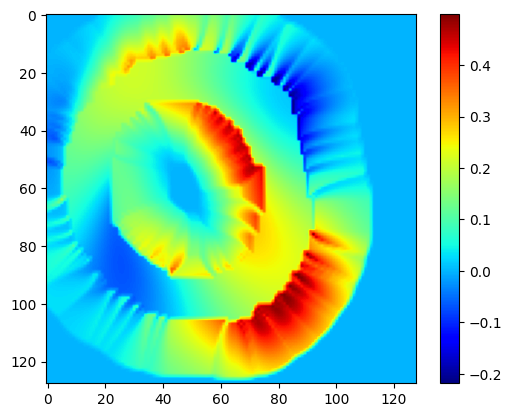

Mean strain values per segment: [0.22538794622311145, 0.14697449904138823, -0.025502309624945953, 0.15302027979737842, 0.09717714787911652, 0.10129088622283634]


In [56]:
import cv2
# strain_map = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/strain5/frame_5_strain.npy")
strain_map = E1
mask = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/npy_masks/patient096_frame01_slice_3_ACDC_#8_2.npy")
# cv2.circle(mask, (64, 64), 40, 1, thickness=-1)  # Example circular myocardium
print("Strain map shape:", strain_map.shape)
print("Mask shape:", mask.shape)
mask = mask == 1
plt.imshow(strain_map, cmap='jet')
plt.colorbar()
plt.show()
means, seg_img = generate_bulls_eye(strain_map, mask)
print("Mean strain values per segment:", means)

In [32]:
import os
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileDataset
from datetime import datetime

def numpy_to_dicom(np_array, output_path, filename):
    # Create meta and dataset
    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom.uid.generate_uid()
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds = FileDataset(filename, {}, file_meta=meta, preamble=b"\0" * 128)

    # Set some dummy patient and scan data
    ds.PatientName = "Test^Patient"
    ds.PatientID = "123456"
    ds.Modality = "MR"
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.SOPClassUID = meta.MediaStorageSOPClassUID

    ds.ImageComments = "Converted from NumPy"
    ds.Rows, ds.Columns = np_array.shape
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelData = (np_array.astype(np.uint16)).tobytes()

    # Add date/time
    dt = datetime.now()
    ds.StudyDate = dt.strftime('%Y%m%d')
    ds.StudyTime = dt.strftime('%H%M%S')

    # Save file
    ds.save_as(os.path.join(output_path, f"{filename}.dcm"))
    print(f"Saved: {filename}.dcm")

# Main loop
input_folder = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5"
output_folder = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom"
os.makedirs(output_folder, exist_ok=True)

for npy_file in os.listdir(input_folder):
    if npy_file.endswith(".npy"):
        np_array = np.load(os.path.join(input_folder, npy_file))
        filename = os.path.splitext(npy_file)[0]
        numpy_to_dicom(np_array, output_folder, filename)

Saved: patient_4d_frame_11.dcm
Saved: patient_4d_frame_10.dcm
Saved: patient_4d_frame_12.dcm
Saved: patient_4d_frame_8.dcm
Saved: patient_4d_frame_9.dcm
Saved: patient_4d_frame_13.dcm
Saved: patient_4d_frame_17.dcm
Saved: patient_4d_frame_16.dcm
Saved: patient_4d_frame_28.dcm
Saved: patient_4d_frame_14.dcm
Saved: patient_4d_frame_15.dcm
Saved: patient_4d_frame_29.dcm
Saved: patient_4d_frame_24.dcm
Saved: patient_4d_frame_18.dcm
Saved: patient_4d_frame_2.dcm
Saved: patient_4d_frame_3.dcm
Saved: patient_4d_frame_19.dcm
Saved: patient_4d_frame_25.dcm
Saved: patient_4d_frame_27.dcm
Saved: patient_4d_frame_1.dcm
Saved: patient_4d_frame_0.dcm
Saved: patient_4d_frame_26.dcm
Saved: patient_4d_frame_22.dcm
Saved: patient_4d_frame_4.dcm
Saved: patient_4d_frame_5.dcm
Saved: patient_4d_frame_23.dcm
Saved: patient_4d_frame_21.dcm
Saved: patient_4d_frame_7.dcm
Saved: patient_4d_frame_6.dcm
Saved: patient_4d_frame_20.dcm


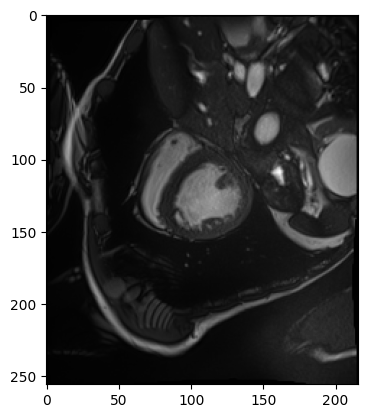

In [46]:
# load and view nifti file
import nibabel as nib
nifti_file = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/training/patient005/patient005_frame01.nii.gz"
nifti_data = nib.load(nifti_file)
nifti_array = nifti_data.get_fdata()
import matplotlib.pyplot as plt
plt.imshow(nifti_array[:, :, 4], cmap='gray')
import numpy as np  

In [51]:
import os
import numpy as np
import nibabel as nib
import pydicom
from pydicom.dataset import FileDataset
from datetime import datetime


def nifti_to_dicom(nifti_file, output_folder):
    """
    Convert a 3D or 4D NIfTI file to multiple 2D DICOM slices,
    using metadata from the NIfTI header. Each 3D volume in a 4D file
    is treated as a separate DICOM series.
    """
    os.makedirs(output_folder, exist_ok=True)

    # Load NIfTI data and header
    nifti_img = nib.load(nifti_file)
    nifti_array = nifti_img.get_fdata()
    affine = nifti_img.affine
    header = nifti_img.header

    # Get spatial metadata from affine and header
    pixel_spacing = list(map(str, header.get_zooms()[:2]))  # (row spacing, column spacing)
    slice_thickness = str(header.get_zooms()[2])
    orientation = affine[:3, :3]  # rotation matrix
    origin = affine[:3, 3]        # origin offset

    # Normalize orientation vectors
    row_cosines = orientation[:, 0] / np.linalg.norm(orientation[:, 0])
    col_cosines = orientation[:, 1] / np.linalg.norm(orientation[:, 1])
    image_orientation = list(map(str, np.concatenate((row_cosines, col_cosines))))

    # Determine number of time points
    if nifti_array.ndim == 4:
        num_timepoints = nifti_array.shape[3]
    else:
        num_timepoints = 1
        nifti_array = nifti_array[..., np.newaxis]  # Convert to shape (X, Y, Z, 1)

    # Patient & Study info
    patient_name = "Converted^Patient"
    patient_id = "123456"
    study_instance_uid = pydicom.uid.generate_uid()

    dt = datetime.now()
    study_date = dt.strftime('%Y%m%d')
    study_time = dt.strftime('%H%M%S')

    for t in range(num_timepoints):
        current_volume = np.transpose(nifti_array[:, :, :, t], (2, 0, 1))  # (slices, rows, cols)
        series_instance_uid = pydicom.uid.generate_uid()

        # Optional: create a subfolder per time frame
        time_output_folder = os.path.join(output_folder, f"time_{t:03}")
        os.makedirs(time_output_folder, exist_ok=True)

        for i, slice_data in enumerate(current_volume):
            filename = os.path.join(time_output_folder, f"slice_{i:03}.dcm")

            file_meta = pydicom.Dataset()
            file_meta.MediaStorageSOPClassUID = pydicom.uid.MRImageStorage
            file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
            file_meta.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID
            file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

            ds = FileDataset(filename, {}, file_meta=file_meta, preamble=b"\0" * 128)
            ds.PatientName = patient_name
            ds.PatientID = patient_id
            ds.Modality = "MR"
            ds.StudyInstanceUID = study_instance_uid
            ds.SeriesInstanceUID = series_instance_uid
            ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
            ds.SOPClassUID = file_meta.MediaStorageSOPClassUID
            ds.StudyDate = study_date
            ds.StudyTime = study_time
            ds.InstanceNumber = i + 1
            ds.Rows, ds.Columns = slice_data.shape
            ds.SamplesPerPixel = 1
            ds.PhotometricInterpretation = "MONOCHROME2"
            ds.BitsAllocated = 16
            ds.BitsStored = 16
            ds.HighBit = 15
            ds.PixelRepresentation = 0
            ds.PixelSpacing = pixel_spacing
            ds.SliceThickness = slice_thickness

            # Compute ImagePositionPatient
            ipp = origin + i * orientation[:, 2]
            ds.ImagePositionPatient = list(map(str, ipp))
            ds.ImageOrientationPatient = image_orientation

            # Set pixel data
            ds.PixelData = (slice_data.astype(np.uint16)).tobytes()

            # Optional: add temporal information
            ds.TemporalPositionIdentifier = t + 1  # non-standard but informative
            ds.NumberOfTemporalPositions = num_timepoints

            ds.save_as(filename)
            print(f"Saved {filename}")


# Example usage

# Example usage
# nifti_file = "/path/to/your.nii.gz"
# output_dir = "/path/to/output/folder"
# nifti_to_dicom(nifti_file, output_dir)
nifti_file = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/training/patient005/patient005_4d.nii.gz"
nifti_to_dicom(nifti_file, "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom")

Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_000.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_001.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_002.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_003.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_004.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_005.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_006.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_007.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_008.dcm
Saved /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/

In [49]:
# extract the information from the dicom file
import pydicom
def extract_dicom_info(dicom_file):
    """
    Extract and print relevant metadata from a DICOM file.
    
    Args:
        dicom_file (str): Path to the DICOM file.
    """
    ds = pydicom.dcmread(dicom_file)
    
    print("Patient Name:", ds.PatientName)
    print("Patient ID:", ds.PatientID)
    print("Modality:", ds.Modality)
    print("Study Instance UID:", ds.StudyInstanceUID)
    print("Series Instance UID:", ds.SeriesInstanceUID)
    print("SOP Instance UID:", ds.SOPInstanceUID)
    print("Image Position Patient:", ds.ImagePositionPatient)
    print("Image Orientation Patient:", ds.ImageOrientationPatient)
    print("Pixel Spacing:", ds.PixelSpacing)
    print("Slice Thickness:", ds.SliceThickness)
    print("Rows:", ds.Rows)
    print("Columns:", ds.Columns)
    print("Bits Allocated:", ds.BitsAllocated)
    print("Bits Stored:", ds.BitsStored)
    print("High Bit:", ds.HighBit)
# Example usage
dicom_file = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5dicom/time_000/slice_000.dcm"
extract_dicom_info(dicom_file)

Patient Name: Converted^Patient
Patient ID: 123456
Modality: MR
Study Instance UID: 1.2.826.0.1.3680043.8.498.70253443588670268521799407642963325064
Series Instance UID: 1.2.826.0.1.3680043.8.498.2213575500600223548175658875325050881
SOP Instance UID: 1.2.826.0.1.3680043.8.498.10674547881663308929074985278034045485
Image Position Patient: [179.296875, -151.171875, -45.0]
Image Orientation Patient: [-1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Pixel Spacing: [1.40625, 1.40625]
Slice Thickness: 10.0
Rows: 256
Columns: 216
Bits Allocated: 16
Bits Stored: 16
High Bit: 15
